In [ ]:
import gc
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
sys.path.insert(1,'/home/bxh220006/software/JnoisePy/src')
import noise_module
from mpi4py import MPI
from scipy.fftpack.helper import next_fast_len
import matplotlib.pyplot  as plt

# ignore warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

'''
This main script of NoisePy:
    1) read the saved noise data in user-defined chunk of inc_hours, cut them into smaller length segments, do 
    general pre-processing (trend, normalization) and then do FFT;
    2) save all FFT data of the same time chunk in memory;
    3) performs cross-correlation for all station pairs in the same time chunk and output the sub-stacked (if 
    selected) into ASDF format;

Authors: Chengxin Jiang (chengxin_jiang@fas.harvard.edu)
         Marine Denolle (mdenolle@fas.harvard.edu)
        
NOTE:
    0. MOST occasions you just need to change parameters followed with detailed explanations to run the script. 
    1. To read SAC/mseed files, we assume the users have sorted the data by the time chunk they prefer (e.g., 1day) 
        and store them in folders named after the time chunk (e.g, 2010_10_1). modify L135 to find your local data; 
    2. A script of S0B_to_ASDF.py is provided to help clean messy SAC/MSEED data and convert them into ASDF format.
        the script takes minor time compared to that for cross-correlation. so we recommend to use S0B script for
        better NoisePy performance. the downside is that it duplicates the continuous noise data on your machine;
    3. When "coherency" is preferred, please set "freq_norm" to "rma" and "time_norm" to "no" for better performance.
'''

tt0=time.time()

########################################
#########PARAMETER SECTION##############
########################################

# absolute path parameters
rootpath  = '.'                                # root path for this data processing
CCFDIR    = os.path.join(rootpath,'Preproc')                                    # dir to store CC data
DATADIR   = os.path.join(rootpath,'RAW_DATA')                               # dir where noise data is located
local_data_path = os.path.join(rootpath,'*')                           # absolute dir where SAC files are stored: this para is VERY IMPORTANT and has to be RIGHT if input_fmt is not h5 for asdf!!!
locations = os.path.join(DATADIR,'station.txt')                             # station info including network,station,channel,latitude,longitude,elevation: only needed when input_fmt is not h5 for asdf

# some control parameters
input_fmt   = 'h5'                                                          # string: 'h5', 'sac','mseed' 
freq_norm   = 'phase_only'                                                  # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'rma'                                                         # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'                                                       # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
flag        = True                                                          # print intermediate variables and computing time for debugging purpose
acorr_only  = False                                                         # only perform auto-correlation 
xcorr_only  = True                                                          # only perform cross-correlation or not
ncomp       = 1                                                             # 1 or 3 component data (needed to decide whether do rotation)

# station/instrument info for input_fmt=='sac' or 'mseed'
stationxml = False                                                          # station.XML file used to remove instrument response for SAC/miniseed data
rm_resp   = 'no'                                                            # select 'no' to not remove response and use 'inv','spectrum','RESP', or 'polozeros' to remove response
respdir   = os.path.join(rootpath,'resp')                                   # directory where resp files are located (required if rm_resp is neither 'no' nor 'inv')
# read station list
if input_fmt != 'h5':
    if not os.path.isfile(locations): 
        raise ValueError('Abort! station info is needed for this script')   
    locs = pd.read_csv(locations)

# pre-processing parameters 
cc_len    = 1800                                                            # basic unit of data length for fft (sec)
step      = 450                                                             # overlapping between each cc_len (sec)
smooth_N  = 10                                                              # moving window length for time/freq domain normalization if selected (points)

# cross-correlation parameters
maxlag         = 200                                                        # lags of cross-correlation to save (sec)
substack       = True                                                       # True = smaller stacks within the time chunk. False: it will stack over inc_hours
                                                                            # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations
                                                                            # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
substack_len   = cc_len                                                     # how long to stack over (for monitoring purpose): need to be multiples of cc_len
smoothspect_N  = 10                                                         # moving window length to smooth spectrum amplitude (points)

# criteria for data selection
max_over_std = 10                                                           # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# maximum memory allowed per core in GB
MAX_MEM = 4.0

# load useful download info if start from ASDF
if input_fmt == 'h5':
    dfile = os.path.join(DATADIR,'download_info.txt')
    down_info = eval(open(dfile).read())
    samp_freq = down_info['samp_freq']
    freqmin   = down_info['freqmin']
    freqmax   = down_info['freqmax']
    start_date = down_info['start_date']
    end_date   = down_info['end_date']
    inc_hours  = down_info['inc_hours']  
    ncomp      = down_info['ncomp'] 
else:   # sac or mseed format
    samp_freq = 20
    freqmin   = 0.05
    freqmax   = 2
    start_date = ["2016_07_01_0_0_0"]
    end_date   = ["2016_07_02_0_0_0"]
    inc_hours  = 24
dt = 1/samp_freq

##################################################
# we expect no parameters need to be changed below

# make a dictionary to store all variables: also for later cc
fc_para={'samp_freq':samp_freq,
         'dt':dt,
         'cc_len':cc_len,
         'step':step,
         'freqmin':freqmin,
         'freqmax':freqmax,
         'freq_norm':freq_norm,
         'time_norm':time_norm,
         'cc_method':cc_method,
         'smooth_N':smooth_N,
         'rootpath':rootpath,
         'CCFDIR':CCFDIR,
         'start_date':start_date[0],
         'end_date':end_date[0],
         'inc_hours':inc_hours,
         'substack':substack,
         'substack_len':substack_len,
         'smoothspect_N':smoothspect_N,
         'maxlag':maxlag,
         'max_over_std':max_over_std,
         'ncomp':ncomp,
         'stationxml':stationxml,
         'rm_resp':rm_resp,
         'respdir':respdir,
         'input_fmt':input_fmt}
# save fft metadata for future reference
fc_metadata  = os.path.join(CCFDIR,'fft_cc_data.txt')       

#######################################
###########PROCESSING SECTION##########
#######################################

#--------MPI---------
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    if not os.path.isdir(CCFDIR):os.mkdir(CCFDIR)
    
    # save metadata 
    fout = open(fc_metadata,'w')
    fout.write(str(fc_para));fout.close()

    # set variables to broadcast
    if input_fmt == 'h5':
        tdir = sorted(glob.glob(os.path.join(DATADIR,'*.h5')))
    else:
        tdir = sorted(glob.glob(local_data_path))
        if len(tdir)==0: raise ValueError('No data file in %s',DATADIR)
        # get nsta by loop through all event folder
        nsta = 0
        for ii in range(len(tdir)):
            tnsta = len(glob.glob(os.path.join(tdir[ii],'*'+input_fmt)))
            if nsta<tnsta:nsta=tnsta

    nchunk = len(tdir)
    splits  = nchunk
    if nchunk==0:
        raise IOError('Abort! no available seismic files for FFT')
else:
    if input_fmt == 'h5':
        splits,tdir = [None for _ in range(2)]
    else: splits,tdir,nsta = [None for _ in range(3)]

# broadcast the variables
splits = comm.bcast(splits,root=0)
tdir  = comm.bcast(tdir,root=0)
if input_fmt != 'h5': nsta = comm.bcast(nsta,root=0)

# MPI loop: loop through each user-defined time chunk
for ick in range (rank,splits,size):
    t10=time.time()   

    #############LOADING NOISE DATA AND DO FFT##################

    # get the tempory file recording cc process
    if input_fmt == 'h5':
        tmpfile = os.path.join(CCFDIR,tdir[ick].split('/')[-1].split('.')[0]+'.h5')
    else: 
        tmpfile = os.path.join(CCFDIR,tdir[ick].split('/')[-1]+'.h5')
    
    # retrive station information
    if input_fmt == 'h5':
        ds=pyasdf.ASDFDataSet(tdir[ick],mpi=False,mode='r') 
        sta_list = ds.waveforms.list()
        nsta=ncomp*len(sta_list)
        print('found %d stations in total'%nsta)
    else:
        sta_list = sorted(glob.glob(os.path.join(tdir[ick],'*'+input_fmt)))
    if (len(sta_list)==0):
        print('continue! no data in %s'%tdir[ick]);continue

    # crude estimation on memory needs (assume float32)
    nsec_chunk = inc_hours/24*86400
    nseg_chunk = int(np.floor((nsec_chunk-cc_len)/step))
    npts_chunk = int(nseg_chunk*cc_len*samp_freq)
    memory_size = nsta*npts_chunk*4/1024**3
    if memory_size > MAX_MEM:
        raise ValueError('Require %5.3fG memory but only %5.3fG provided)! Reduce inc_hours to avoid this issue!' % (memory_size,MAX_MEM))

    nnfft = int(next_fast_len(int(cc_len*samp_freq)))
    # open array to store fft data/info in memory
    fft_array = np.zeros((nsta,nseg_chunk*(nnfft//2)),dtype=np.complex64)
    fft_std   = np.zeros((nsta,nseg_chunk),dtype=np.float32)
    fft_flag  = np.zeros(nsta,dtype=np.int16)
    fft_time  = np.zeros((nsta,nseg_chunk),dtype=np.float64) 
    # station information (for every channel)
    station=[];network=[];channel=[];clon=[];clat=[];location=[];elevation=[]     
    
    with pyasdf.ASDFDataSet(tmpfile,mpi=False,compression="gzip-3",mode='a') as ds_preproc:
        # loop through all stations
        iii = 0
        for ista in range(len(sta_list)):
            tmps = sta_list[ista]

            if input_fmt == 'h5':
                # get station and inventory
                try:
                    inv1 = ds.waveforms[tmps]['StationXML']
                except Exception as e:
                    print('abort! no stationxml for %s in file %s'%(tmps,tdir[ick]))
                    continue
                sta,net,lon,lat,elv,loc = noise_module.sta_info_from_inv(inv1)

                # get days information: works better than just list the tags 
                all_tags = ds.waveforms[tmps].get_waveform_tags()
                if len(all_tags)==0:continue
            
            else: # get station information
                all_tags = [1]
                sta = tmps.split('/')[-1]

            #----loop through each stream----
            for itag in range(len(all_tags)):
                if flag:print("working on station %s and trace %s" % (sta,all_tags[itag]))

                # read waveform data
                if input_fmt == 'h5':
                    source = ds.waveforms[tmps][all_tags[itag]]
                else:
                    source = obspy.read(tmps)
                    inv1   = noise_module.stats2inv(source[0].stats,fc_para,locs)
                    sta,net,lon,lat,elv,loc = noise_module.sta_info_from_inv(inv1)

                # channel info 
                comp = source[0].stats.channel
                if comp[-1] =='U': comp.replace('U','Z')
                if len(source)==0:continue

                dataS = source[0].data
                dataS = noise_module.demean(dataS)
                dataS = noise_module.detrend(dataS)
                dataS = noise_module.taper(dataS)
                # do normalization if needed
                #------to normalize in time or not------
                N = dataS.shape[0]
                if time_norm != 'no':
                    if time_norm == 'one_bit': 	# sign normalization
                        white = np.sign(dataS)
                    elif time_norm == 'rma': # running mean: normalization over smoothed absolute average
                        white = np.zeros(shape=dataS.shape,dtype=dataS.dtype)
                        white[:] = dataS[:]/noise_module.moving_ave(np.abs(dataS[:]),smooth_N)
                else:# don't normalize
                    white = dataS

                #-----to whiten or not------
                if freq_norm != 'no':
                    whiten = noise_module.whiten_backto_time(white,fc_para)	# whiten and return FFT
                else:
                    whiten = white
                source[0].data=whiten
                if len(source): 
                    #new_tags = '{0:s}_{1:s}'.format(chan[ista].lower(),tlocation.lower())
                    new_tags = all_tags[itag]
                    
                    ds_preproc.add_waveforms(source,tag=new_tags)
                
                iii+=1
            

    # check whether array size is enough
    if iii!=nsta:
        print('it seems some stations miss data in download step, but it is OKAY!')

    
    t11 = time.time()
    print('it takes %6.2fs to process the chunk of %s' % (t11-t10,tdir[ick].split('/')[-1]))

tt1 = time.time()
print('it takes %6.2fs to process step 1 in total' % (tt1-tt0))
comm.barrier()

# merge all path_array and output
if rank == 0:
    print("Data preprocessing with sample_freq=%d finished!!!"%(samp_freq))

In [ ]:
print(dataS.shape)

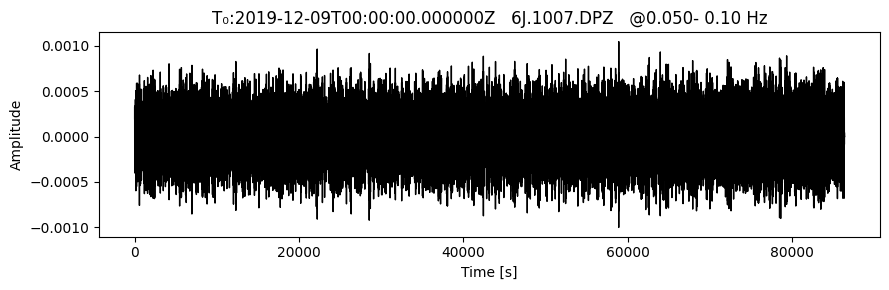

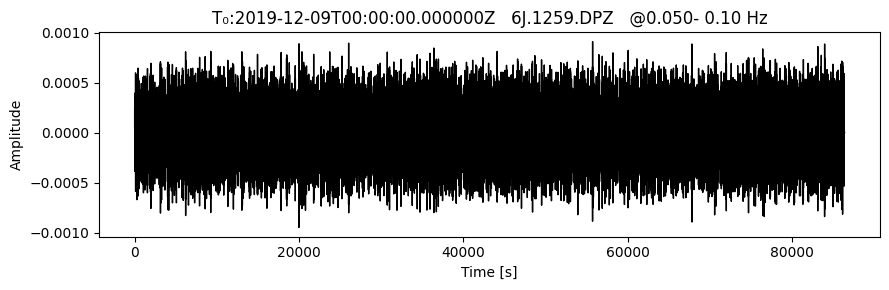

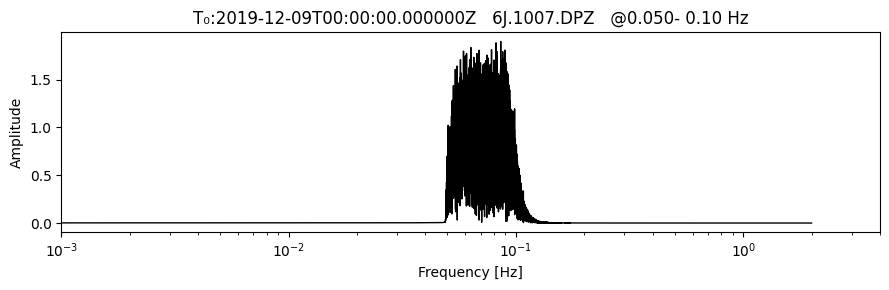

In [2]:
import sys
sys.path.insert(1,'/home/bxh220006/software/JnoisePy/src')
import plotting_modules #(cd to your source file directory first before loading this module)
sfile = './Preproc/2019_12_09_00_00_00T2019_12_10_00_00_00.h5'
plotting_modules.plot_waveform(sfile,'6J','1007',0.05,0.1)
plotting_modules.plot_waveform(sfile,'6J','1259',0.05,0.1)
plotting_modules.plot_waveform_spec(sfile,'6J','1007',0.05,0.1)